In [42]:
import pandas as pd
import numpy  as np
import scipy.io as io
from scipy.signal import periodogram, welch
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
import pywt
import mne
import gc
import warnings
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size': 18})
sns.set_theme()
%matplotlib inline
warnings.filterwarnings("ignore")

# Data Science With EEG Signals

## Ingest

In order to ingest the EEG data we will be using the **mne** lib which brings lot of pre-built usefuel functionalities that will help in the data load and anlaysis of EEG signal.

In [3]:
# Dataset description:
# https://www.physionet.org/content/eegmmidb/1.0.0/
# https://www.bbci.de/competition/iv/desc_2a.pdf

### Loading BCICIV 2a Dataset

In [4]:
file_name = 'data/BCICIV_2a_gdf-dataset/A02E.gdf' 
ch_types = [22,23,24]
raw_gdf = mne.io.read_raw_gdf(file_name, eog=ch_types)
raw_gdf

Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\BCICIV_2a_gdf-dataset\A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


<RawGDF | A02E.gdf, 25 x 662666 (2650.7 s), ~28 kB, data not loaded>

For this specifc dataset we have 9 individuals which peformed 2 sessions of EEG data aquisition, with 1 session (+-45 minutes) intended for training data and 1 session (+-45 minutes) for testing data. Each session is divided in the following steps:


>
>    1. EOG Eyes open
>    2. EOG Eyes closed
>    3. EOG Movement
>    4. Run 1
>    5. Run 2
>    6. Run 3
>    7. Run 4
>    8. Run 5
>    9. Run 6



At the beginning of each session, a recording of approximately 5 minutes
was performed to estimate the EOG influence. The recording was divided
into 3 blocks: (1) two minutes with eyes open (looking at a fixation cross
on the screen), (2) one minute with eyes closed, and (3) one minute with
eye movements. 





In [5]:
x_sample = raw_gdf.get_data()[0]

In [107]:
raw_gdf.get_channel_types()

['eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eog',
 'eog',
 'eog']

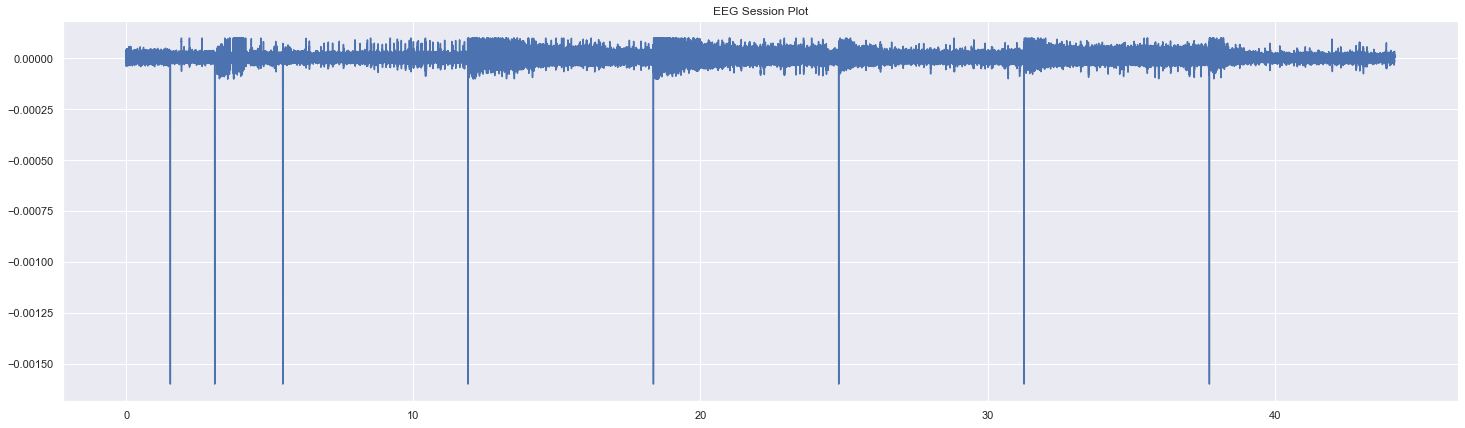

In [6]:
n_points = len(raw_gdf.get_data()[0])
minutes = (n_points / 250 ) / 60

plt.figure(figsize=(25,7))
sns.lineplot(x=np.linspace(0,minutes,n_points), y=x_sample).set_title("EEG Session Plot");

As you can se on the chart above, there are some samples that indicates the end of each Run. 

**Runs:**

One run consists of 48 trials (12 for each of the four possible
classes), yielding a total of 288 trials per session.

**Preprocessing**
1. In order to have the data formated for training firtly it is needed to cut the signal based on the thersholds so that we will have the Runs separated in different arrays.

2. Next up, we will get rid of the first 3 chunks of data (EOG signal) and than work only with the Run's data.

3. Since each Run has 48 trails, we will split them into differents arrays. Notice that there is an order in which the trails classes were recorded. `[ left hand => right hand => foot => tongue => left hand ... ] ` Considering that, we also will put the signals from differents classes in their respectives arrays.

4. A trial is subdivided into 4 short steps:
`[ Fixation Cross (2seg) => Cue (1seg) => Motor Imaginary (3seg) => Break(1.5seg) ... ] `.
In our case we will only use the `Motor Imaginary` data, that represents the period o time the individual is imagining tasks movements, so that next step will be to slice the trials to extract this specific data. To ensure that we extract every sample of the signal, we are adding half a second up and down when extractiong the signal segment.


> Looking for strategies to split the Runs

In [7]:
eeg_data = raw_gdf.get_data()

In [8]:
fig = plt.figure(figsize=(30,30))

gs1 = gridspec.GridSpec(5, 5)
countries = ["EEG " + str(i) for i in range(1, 26)]
axs = []
for c, num in zip(countries, range(0,25)):
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].hist(eeg_data[num],bins=40, log=True)

plt.show()

Based on the histograms plotted in logarithmic scale we can see that the threshold is very far from the true signal data, so that we can use it with no concerns in dividing the Runs.

Let's check the exact threshold values for each EEG channel  to use in creating the logic.

In [9]:
[min(data) for data in raw_gdf.get_data() if min(data) <=  -0.0015 ] 

[-0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.0015999999999999999,
 -0.016,
 -0.016,
 -0.016]

In [10]:
signal = raw_gdf.get_data()[0]
signal_len = len(signal)

start = 0
end = 0
signals = []

for i in range(signal_len):
    if (signal[i] <= -0.0015) and (signal[end] >= -0.0015):
        end = i
        signals.append([channel[start:end] for channel in eeg_data])
        print(f'Condition I | index=> {i}, start=> {start}, end=> {end}')
        
    elif (signal[i] >= -0.0015) and (signal[end] <= -0.0015):
        start = i
        end = i
        print(f'Condition II | index=> {i}, start=> {start}, end=> {end}')
        
    elif (i + 1 == signal_len) and (start == end) and (start != i) :
        end = i
        signals.append([channel[start:end] for channel in eeg_data])
        print(f'Condition III | index=> {i}, start=> {start}, end=> {end}')


Condition I | index=> 22901, start=> 0, end=> 22901
Condition II | index=> 23001, start=> 23001, end=> 23001
Condition I | index=> 46116, start=> 23001, end=> 46116
Condition II | index=> 46216, start=> 46216, end=> 46216
Condition I | index=> 81656, start=> 46216, end=> 81656
Condition II | index=> 81756, start=> 81756, end=> 81756
Condition I | index=> 178491, start=> 81756, end=> 178491
Condition II | index=> 178591, start=> 178591, end=> 178591
Condition I | index=> 275326, start=> 178591, end=> 275326
Condition II | index=> 275426, start=> 275426, end=> 275426
Condition I | index=> 372161, start=> 275426, end=> 372161
Condition II | index=> 372261, start=> 372261, end=> 372261
Condition I | index=> 468996, start=> 372261, end=> 468996
Condition II | index=> 469096, start=> 469096, end=> 469096
Condition I | index=> 565831, start=> 469096, end=> 565831
Condition II | index=> 565931, start=> 565931, end=> 565931
Condition III | index=> 662665, start=> 565931, end=> 662665


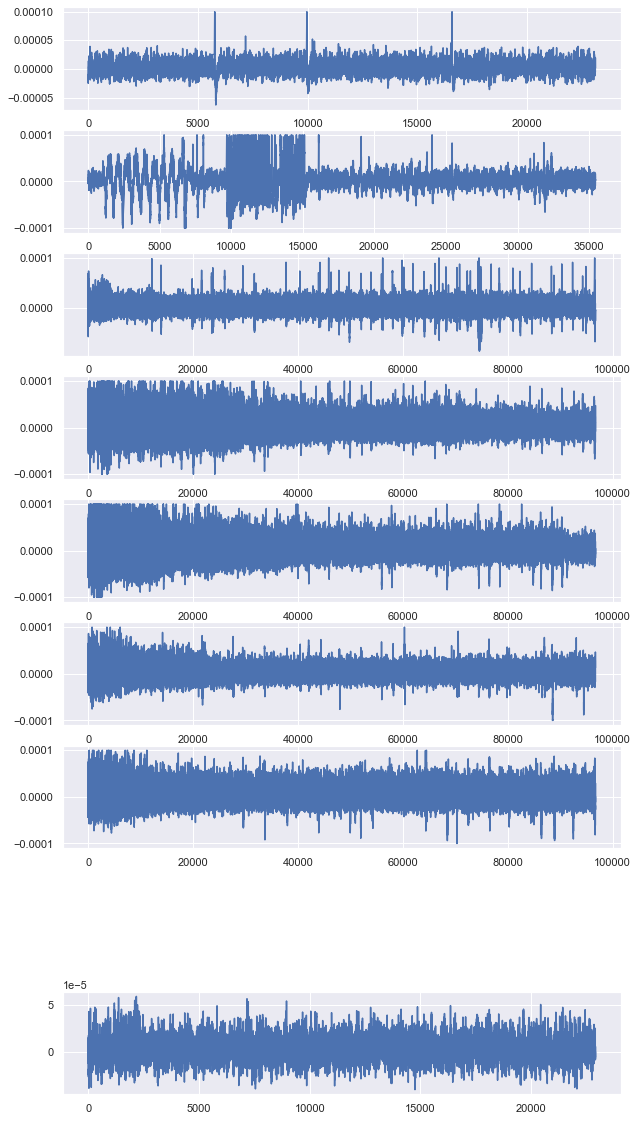

In [11]:
fig = plt.figure(figsize=(10,20))

gs1 = gridspec.GridSpec(9, 1)
countries = ["Channel " + str(i) for i in range(1, 9)]
axs = []
for c, num in zip(countries, range(0,8)):
    axs.append(fig.add_subplot(gs1[num - 1]))
    axs[-1].plot(signals[num][0])

plt.show()

As you can see on those plots above the Runs were splited and the negative peaks (threshold) desapeared.


In the cell below you can see tha complete function responsible to load all data present in the dataset folder and provide x and y sample data that will be used on training and testing.

> Creating functions for laod all data

In [12]:

def load_eeg_data(directory:str, extension:str):
    file_name_list = list(Path(directory).glob(extension))
    imaginary_tasks_signal_list = {
        "left_hand":[], "right_hand":[], 
        "both_feet":[], "tongue":[]
        }
    ch_types = [22,23,24]

    for file_name in file_name_list:
        raw = mne.io.read_raw_gdf(file_name, eog=ch_types)
        eeg_data = raw.get_data()
        runs = split_row_signal_in_runs(eeg_data)
        for run in runs[3:]:
            split_run_in_class_trails(run, imaginary_tasks_signal_list)

    x = np.concatenate((
            imaginary_tasks_signal_list["left_hand"],
            imaginary_tasks_signal_list["right_hand"],
            imaginary_tasks_signal_list["both_feet"],
            imaginary_tasks_signal_list["tongue"]
            ),axis=0)

    n_trials_class1 = np.shape(imaginary_tasks_signal_list["left_hand"])[0]
    n_trials_class2 = np.shape(imaginary_tasks_signal_list["right_hand"])[0]
    n_trials_class3 = np.shape(imaginary_tasks_signal_list["both_feet"])[0]
    n_trials_class4 = np.shape(imaginary_tasks_signal_list["tongue"])[0]

    y = np.concatenate((
            np.full((n_trials_class1), 0),
            np.full((n_trials_class2), 1),
            np.full((n_trials_class3), 2),
            np.full((n_trials_class4), 3)
            ),axis=0)
    return x, y


def split_row_signal_in_runs(eeg_data):
    signal = eeg_data[0]
    signal_len = len(signal)

    start = 0
    end = 0
    runs = []

    for i in range(signal_len):
        if (signal[i] <= -0.0015) and (signal[end] >= -0.0015):
            end = i
            runs.append([channel[start:end] for channel in eeg_data])
            # print(f'Cond I | index=> {i}, start=> {start}, end=> {end}')
            
        elif (signal[i] >= -0.0015) and (signal[end] <= -0.0015):
            start = i
            end = i
            # print(f'Cond II | index=> {i}, start=> {start}, end=> {end}')
            
        elif (i + 1 == signal_len) and (start == end) and (start != i) :
            end = i
            runs.append([channel[start:end] for channel in eeg_data])
            # print(f'Cond III | index=> {i}, start=> {start}, end=> {end}')
    return runs

def split_run_in_class_trails(run, imaginary_tasks_dict):
    run_len = len(run[0])
    window_len = 8 * 250 # 8 seconds x 250Hz = number of samples for each trial
    class_count = 1 

    for start_point in range(0, run_len, window_len): # range(start, stop, stride)
        end_point = start_point + window_len
        if end_point >= run_len:
            break
        else:
            channels_slice = [channel[start_point:end_point] for channel in run]

        motor_imaginary_signal = get_motor_imaginary_section(channels_slice)
        set_signal_in_its_task_list(
            motor_imaginary_signal,
            class_count,
            imaginary_tasks_dict
            )
        
        class_count+=1
        if class_count > 4:
            class_count = 1

    n =  [len(imaginary_tasks_dict[d]) for d in imaginary_tasks_dict.keys()]   
    # print(f'Nº trials: {n}')    

def get_motor_imaginary_section(data):
    start = round(2.5 * 250) # It starts in 3 seconds but we are choosing 2.5 for approx matters
    end = round(6.5 * 250)
    return [d[start:end] for d in data]

def set_signal_in_its_task_list(
    motor_imaginary_signal,
    class_count,
    imaginary_tasks_dict):

    if class_count == 1:
        imaginary_tasks_dict["left_hand"].append(motor_imaginary_signal)

    elif class_count == 2:
        imaginary_tasks_dict["right_hand"].append(motor_imaginary_signal)

    elif class_count == 3:
        imaginary_tasks_dict["both_feet"].append(motor_imaginary_signal)

    elif class_count == 4:
        imaginary_tasks_dict["tongue"].append(motor_imaginary_signal)



In [13]:
directory = 'data/BCICIV_2a_gdf-dataset' 
extension_train = '*T.gdf'
extension_evaluation = '*E.gdf'

x_train_BCICIV, y_train_BCICIV = load_eeg_data(directory, extension_train)
x_test_BCICIV, y_test_BCICIV = load_eeg_data(directory, extension_evaluation)

Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\BCICIV_2a_gdf-dataset\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\BCICIV_2a_gdf-dataset\A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\BCICIV_2a_gdf-dataset\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they

In [14]:
print(x_train_BCICIV.shape)
print(y_train_BCICIV.shape)
print(x_test_BCICIV.shape)
print(y_test_BCICIV.shape)

(2496, 25, 1000)
(2496,)
(2592, 25, 1000)
(2592,)


### Loading EEG Motor Movement Imagery Dataset

This data set consists of over 1500 one- and two-minute EEG recordings, obtained from 109 volunteers, as described below.



In summary, the experimental runs were:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

In [15]:
file_name = 'data/eeg-motor-movementimagery-dataset/files/S001/S001R04.edf' 

ch_types = [22,23,24]

raw_edf = mne.io.read_raw_edf(file_name)

Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [16]:
raw_edf

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~64 kB, data not loaded>

In [17]:
plt.plot(raw_edf.get_data());

since the trails are separated by file, this dataset will be easier to load than the first one

> Creating functions for laod all data

In [18]:
def load_eeg_data_2(directory, extension):
    
    p = Path(directory)
    file_name_list = [x for x in p.glob(extension) if not x.name.endswith("02.edf") and not x.name.endswith("01.edf") ]
    imaginary_tasks_signal_list = {
        "open_close_fist":[], "imagine_open_close_fist":[], 
        "both_feet":[], "imagine_both_feet":[]
        }


    for file_name in file_name_list:
        raw = mne.io.read_raw_edf(file_name)
        eeg_trail = raw.get_data()
        split_run_in_class_trails(eeg_trail, imaginary_tasks_signal_list, str(file_name))
        del raw
        del eeg_trail
        gc.collect()

    x = np.concatenate((
            imaginary_tasks_signal_list["open_close_fist"],
            imaginary_tasks_signal_list["imagine_open_close_fist"],
            imaginary_tasks_signal_list["both_feet"],
            imaginary_tasks_signal_list["imagine_both_feet"]
            ),axis=0)

    n_trials_class1 = np.shape(imaginary_tasks_signal_list["open_close_fist"])[0]
    n_trials_class2 = np.shape(imaginary_tasks_signal_list["imagine_open_close_fist"])[0]
    n_trials_class3 = np.shape(imaginary_tasks_signal_list["both_feet"])[0]
    n_trials_class4 = np.shape(imaginary_tasks_signal_list["imagine_both_feet"])[0]
    y = np.concatenate((
            np.full((n_trials_class1), 0),
            np.full((n_trials_class2), 1),
            np.full((n_trials_class3), 2),
            np.full((n_trials_class4), 3)
            ),axis=0)
    return x, y


def split_run_in_class_trails(run, imaginary_tasks_dict, file_name):
    
    def set_padding(signal, start_point, audio_len, window_len):
        incomplete_data = signal[start_point:audio_len]
        audio_with_padding = np.zeros(window_len)
        audio_with_padding[:len(incomplete_data)] = incomplete_data
        return audio_with_padding

    run_len = len(run[0])
    window_len = 4 * 160 # 8 seconds x 160Hz = number of samples for each row of data


    for start_point in range(0, run_len, window_len): # range(start, stop, stride)
        end_point = start_point + window_len
        if end_point >= run_len:
            channels_slice = [set_padding(signal, start_point, run_len, window_len) for signal in run]
        else:
            channels_slice = [channel[start_point:end_point] for channel in run]

        set_signal_in_dict(
            channels_slice,
            file_name,
            imaginary_tasks_dict
            )
        


    n =  [len(imaginary_tasks_dict[d]) for d in imaginary_tasks_dict.keys()]   
    print(f'Nº trials: {n}')    


def set_signal_in_dict(
    motor_imaginary_signal,
    file_name,
    imaginary_tasks_dict):

    if ('R03' in file_name) or ('R07' in file_name) or ('R11' in file_name):
        imaginary_tasks_dict["open_close_fist"].append(motor_imaginary_signal)

    elif('R04' in file_name) or ('R08' in file_name) or ('R12' in file_name):
        imaginary_tasks_dict["imagine_open_close_fist"].append(motor_imaginary_signal)

    elif ('R05' in file_name) or ('R09' in file_name) or ('R13' in file_name):
        imaginary_tasks_dict["both_feet"].append(motor_imaginary_signal)

    elif ('R06' in file_name) or ('R10' in file_name) or ('R14' in file_name):
        imaginary_tasks_dict["imagine_both_feet"].append(motor_imaginary_signal)


In [40]:
directory = 'data/eeg-motor-movementimagery-dataset/files/'
extension = '**/*.edf'

x_movementimagery, y_movementimagery  = load_eeg_data_2(directory, extension)

Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Nº trials: [32, 0, 0, 0]
Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Nº trials: [32, 32, 0, 0]
Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Nº trials: [32, 32, 32, 0]
Extracting EDF parameters from c:\Users\msant429\Desktop\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Nº trials: [32, 32, 32, 32]
Extracting EDF parameters from c:\Users\msant429\Desktop\T

In [41]:
print(x_movementimagery.shape)
print(y_movementimagery.shape)

(40585, 64, 640)
(40585,)


## EDA

In [9]:
# Use it as baseline
# https://www.kaggle.com/code/ruslankl/eeg-data-analysis


### Surface plot for each class

In [50]:
def plot_surface(eeg_signal, channel_ticks, channel_string, title):
    fig = go.Figure(data=[go.Surface(z=eeg_signal)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                    highlightcolor="limegreen", project_z=True))
    fig.update_layout(title=title, autosize=False,
                    scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                    width=1000, height=700,
                    margin=dict(l=20, r=20, b=20, t=50),
                    scene=dict(
                            xaxis=dict(
                                title='Time (sample num)',
                            ),
                            yaxis=dict(
                                title='Channel',
                                tickvals=channel_ticks,
                                ticktext=channel_string,
                            )
                           
                        )
                    )
    fig.show()

def plot_specgram(signal, fs, title ):
    plt.title(title)
    plt.grid(False)
    plt.specgram(signal,  NFFT=5000, Fs=fs, noverlap=400, cmap='inferno')
    plt.colorbar()
    plt.show()

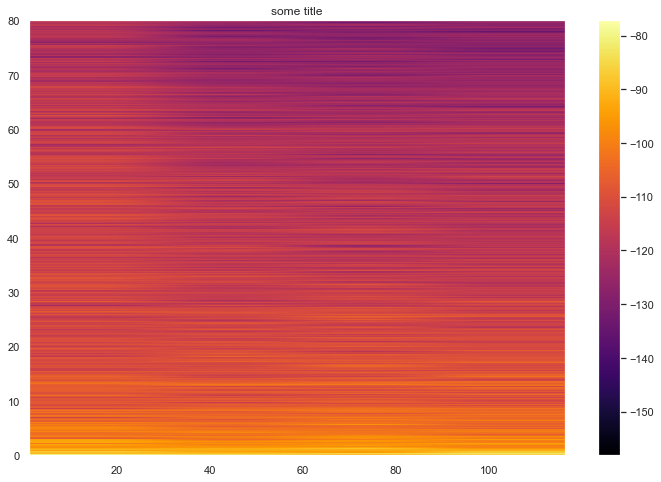

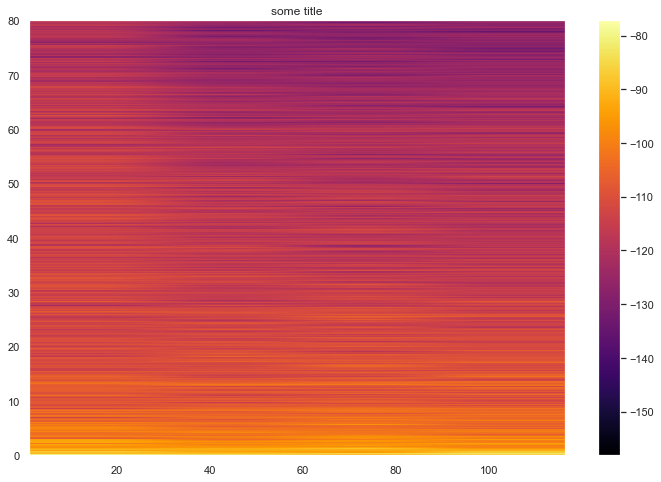

In [117]:
plot_specgram(signal=raw_edf.get_data()[30], fs=160, title="some title" )
plot_specgram(signal=raw_edf.get_data()[30], fs=160, title="some title" )
plot_specgram(signal=raw_edf.get_data()[30], fs=160, title="some title" )

In [41]:
channels_ = [n for n in range(1,65)]
channels = ['Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6','C5','C3','C1','Cz','C2','C4','C6','Cp5','Cp3',
'Cp1','Cpz','Cp2','Cp4','Cp6','Fp1','Fpz','Fp2','Af7','Af3','Afz','Af4','Af8','F7','F5','F3','F1','Fz',
'F2','F4','F6','F8','Ft7','Ft8','T7','T8','T9','T10','Tp7','Tp8','P7','P5','P3','P1','Pz','P2','P4','P6',
'P8','Po7','Po3','Poz','Po4','Po8','O1','Oz','O2','Iz']

In [55]:
plot_surface(
    eeg_signal=np.array(data['open_close_fist'][0]), 
    channel_ticks=channels_, 
    channel_string=channels, 
    title= 'EEG Signal 64 Channels - Open Close Fist'
    )

In [56]:
plot_surface(
    eeg_signal=np.array(data['imagine_open_close_fist'][0]), 
    channel_ticks=channels_, 
    channel_string=channels, 
    title= 'EEG Signal 64 Channels - Imagining Open Close Fist'
    )

In [57]:
plot_surface(
    eeg_signal=np.array(data['both_feet'][0]), 
    channel_ticks=channels_, 
    channel_string=channels, 
    title= 'EEG Signal 64 Channels - Both Feet'
    )

In [58]:
plot_surface(
    eeg_signal=np.array(data['imagine_both_feet'][0]), 
    channel_ticks=channels_, 
    channel_string=channels, 
    title= 'EEG Signal 64 Channels - Imagining Both Feet'
    )

## Modeling

### Train | Test split

### Machine Learning Models

#### Feature Extraction

##### Time Domain

In [62]:
def preprocessing(data):
    features = np.zeros((
        data.shape[0],
        get_features(get_wavelet_decomposition(data[0])).shape[0]
        ))
    for i, row in enumerate(data):
        features[i] = get_features(get_wavelet_decomposition(row))   
    return features

def get_wavelet_decomposition(list_values):
    dec_wave_lvs = pywt.wavedec(list_values, 'coif1', level=2) 
    return dec_wave_lvs[0]

def get_features(list_values):
    # Standard Deviation
    std = np.nanstd(list_values)
    # Variance
    var = np.nanvar(list_values)
    # Rms
    rms = np.nanmean(np.sqrt(list_values**2))
    # Norm Entropy
    n_etp = norm_entropy(list_values)
    # Entropy
    entropy = spectral_entropy(list_values, 100, method='welch', normalize=True)   
    return np.hstack([std, var, rms, n_etp, entropy])

def norm_entropy(x):
    tresh = 2
    return sum(np.power(abs(x),tresh))

def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False, axis=-1):
    x = np.asarray(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf, axis=axis)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -_xlogx(psd_norm).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se

def _xlogx(x, base=2):
    """Returns x log_b x if x is positive, 0 if x == 0, and np.nan
    otherwise. This handles the case when the power spectrum density
    takes any zero value.
    """
    x = np.asarray(x)
    xlogx = np.zeros(x.shape)
    xlogx[x < 0] = np.nan
    valid = x > 0
    xlogx[valid] = x[valid] * np.log(x[valid]) / np.log(base)
    return xlogx

In [63]:
features_train = preprocessing(x_train_BCICIV)
features_test = preprocessing(x_test_BCICIV)

In [61]:
features.shape

(2496, 281)

In [ ]:
print(x_train_BCICIV.shape)
print(y_train_BCICIV.shape)
print(x_test_BCICIV.shape)
print(y_test_BCICIV.shape)

##### Frequency Domain

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import xgboost as xgb
from sklearn import svm

In [92]:
import random

idx = np.random.randint(0, x_movementimagery.shape[0], 5000)
x, y = x_movementimagery[idx], y_movementimagery[idx]

In [100]:
from moabb.datasets import BNCI2014001
dataset = BNCI2014001()

In [105]:
dataset.subject_list = [1, 2, 3]
sessions = dataset.get_data(subjects=[1])

KeyboardInterrupt: 

In [103]:
dataset.download()

MNE_DATA is not already configured. It will be set to default location in the home directory - C:\Users\msant429\mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
C:\Users\msant429\.mne\mne-python.json


  1%|4                                     | 493k/42.8M [00:29<48:05, 14.7kB/s]

KeyboardInterrupt: 

  1%|4                                     | 508k/42.8M [00:40<48:04, 14.7kB/s]

#### Training

In [94]:
features_train = preprocessing(x)


# X_train, X_test, y_train, y_test = train_test_split(x_movementimagery, y_movementimagery, test_size=0.33, random_state=42)

In [98]:
lda = LDA()
SVM_clf = svm.SVC(kernel='linear', C = 1.0)

lda_scores_Method1 = cross_val_score(SVM_clf, features_train, y, cv=5, scoring='accuracy')

In [99]:
lda_scores_Method1.mean()

0.3036

#### Metrics

In [81]:
lda_scores_Method1.mean()

nan

### Deep Learning Models

#### CNN - Any CNN Architecture

#### LSTM - Any LSTM Architecture 

#### Transformers Architecture

#### Metrics

In [284]:
#### Inference time 

## Conclusion